# Pytorch 可视化

In [36]:
import numpy as np
import torch
import torchvision.models as models  # torchvision.models 内部有内嵌和很多的模型，可以直接调用
from torchvision.models import vgg11,resnet18,resnet101,resnext101_32x8d  # 导入 vgg11, resnet18, resnet101, resnext101_32x8d
from torchvision import transforms

from torchinfo import summary  # 可视化模型结构
from pytorch_grad_cam import GradCAM,ScoreCAM,GradCAMPlusPlus,AblationCAM,XGradCAM,EigenCAM,FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from PIL import Image

import matplotlib.pyplot as plt  # 制图

## 1.可视化网络结构


In [2]:
resnet18 = models.resnet18()

# 我们可以发现单纯的print(model)，只能得出基础构件的信息，既不能显示出每一层的shape，也不能显示对应参数量的大小
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# torchinfo提供了更加详细的信息
# 包括模块信息（每一层的类型、输出shape和参数量）
# 模型整体的参数量
# 模型大小
# 一次前向或者反向传播需要的内存大小等
summary(resnet18, (1, 3, 224, 224))  # 1：batch_size 3:图片的通道数 224: 图片的高宽


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## 2.CNN可视化

CNN是一个“黑盒模型”，人们并不知道CNN是如何获得较好表现的，由此带来了深度学习的可解释性问题

理解CNN的重要一步是可视化，包括可视化特征是如何提取的、提取到的特征的形式以及模型在输入数据上的关注点等

- 可视化CNN卷积核的方法

- 可视化CNN特征图的方法

- 可视化CNN显著图（class activation map）的方法

In [4]:
# model = vgg11(pretrained=True)
# UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = vgg11(weights=True)

# model.features:
# 通常表示一个包含若干层的子模块，例如卷积层、池化层等。
# 具体取决于模型的定义。
# named_children(): 
# return -> (name, module)
print(dict(model.features.named_children()))

a:\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '1': ReLU(inplace=True), '2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '3': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '4': ReLU(inplace=True), '5': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '6': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '7': ReLU(inplace=True), '8': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '9': ReLU(inplace=True), '10': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '11': Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '12': ReLU(inplace=True), '13': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '14': ReLU(inplace=True), '15': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), '16': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), '17'

```shell
{
    '0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '1': ReLU(inplace=True), 
    '2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),  
    '3': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '4': ReLU(inplace=True),
    '5': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    '6': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '7': ReLU(inplace=True),
    '8': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '9': ReLU(inplace=True),
    '10': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    '11': Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '12': ReLU(inplace=True),
    '13': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '14': ReLU(inplace=True),
    '15': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    '16': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '17': ReLU(inplace=True),
    '18': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    '19': ReLU(inplace=True),
    '20': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
}
```

### 2.1 CNN 卷积核可视化

In [ ]:
conv1 = dict(model.features.named_children())['3']
# Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# kernel_set = conv1.weight

# detach() 方法用于从当前计算图中分离张量。它返回一个新的张量，该张量与原始张量共享相同的数据，但是不再追踪梯度。
kernel_set = conv1.weight.detach()
# kernel_set.dtype  # torch.float32
num = len(conv1.weight.detach())  # 128
print(kernel_set.shape)  # torch.Size([128, 64, 3, 3])

# for i in range(0,num):
#     i_kernel = kernel_set[i]
#     plt.figure(figsize=(24, 24))
#     if (len(i_kernel)) > 1:
#         for idx, filer in enumerate(i_kernel):
#             plt.subplot(9, 9, idx+1) 
#             plt.axis('off')
#             plt.imshow(filer[ :, :].detach(),cmap='bwr')

### 2.2 CNN特征图可视化

与卷积核相对应，输入的原始图像经过每次卷积层得到的数据称为特征图，可视化卷积核是为了看模型提取哪些特征，可视化特征图则是为了看模型提取到的特征是什么样子的。

获取特征图的方法有很多种，可以从输入开始，逐层做前向传播，直到想要的特征图处将其返回。尽管这种方法可行，但是有些麻烦了。在PyTorch中，提供了一个专用的接口使得网络在前向传播过程中能够获取到特征图，这个接口的名称非常形象，叫做hook

In [9]:
class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []

    def __call__(self, module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None


def plot_feature(model, idx, inputs):
    hh = Hook()
    model.features[idx].register_forward_hook(hh)

    # forward_model(model,False)
    model.eval()
    _ = model(inputs)
    print(hh.module_name)
    print((hh.features_in_hook[0][0].shape))
    print((hh.features_out_hook[0].shape))

    out1 = hh.features_out_hook[0]

    total_ft = out1.shape[1]
    first_item = out1[0].cpu().clone()

    plt.figure(figsize=(20, 20))

    for ftidx in range(total_ft):
        if ftidx > 99:
            break
        ft = first_item[ftidx]
        plt.subplot(10, 10, ftidx + 1)

        plt.axis("off")
        # plt.imshow(ft[ :, :].detach(),cmap='gray')
        plt.imshow(ft[:, :].detach())

In [27]:
# 图像预处理
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0)  # Add batch dimension

hooker working <__main__.Hook object at 0x000001A7DD99D3D0>
hooker working <__main__.Hook object at 0x000001A8863262D0>
hooker working <__main__.Hook object at 0x000001A7EB2EF610>
hooker working <__main__.Hook object at 0x000001A83CB9EE50>
hooker working <__main__.Hook object at 0x000001A85177FF50>
hooker working <__main__.Hook object at 0x000001A70D892210>
hooker working <__main__.Hook object at 0x000001A8599D0650>
hooker working <__main__.Hook object at 0x000001A85B9F1E90>
hooker working <__main__.Hook object at 0x000001A837693390>
hooker working <__main__.Hook object at 0x000001A83C7978D0>
hooker working <__main__.Hook object at 0x000001A850AE0950>
[<class 'torch.nn.modules.pooling.MaxPool2d'>]
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 28, 28])


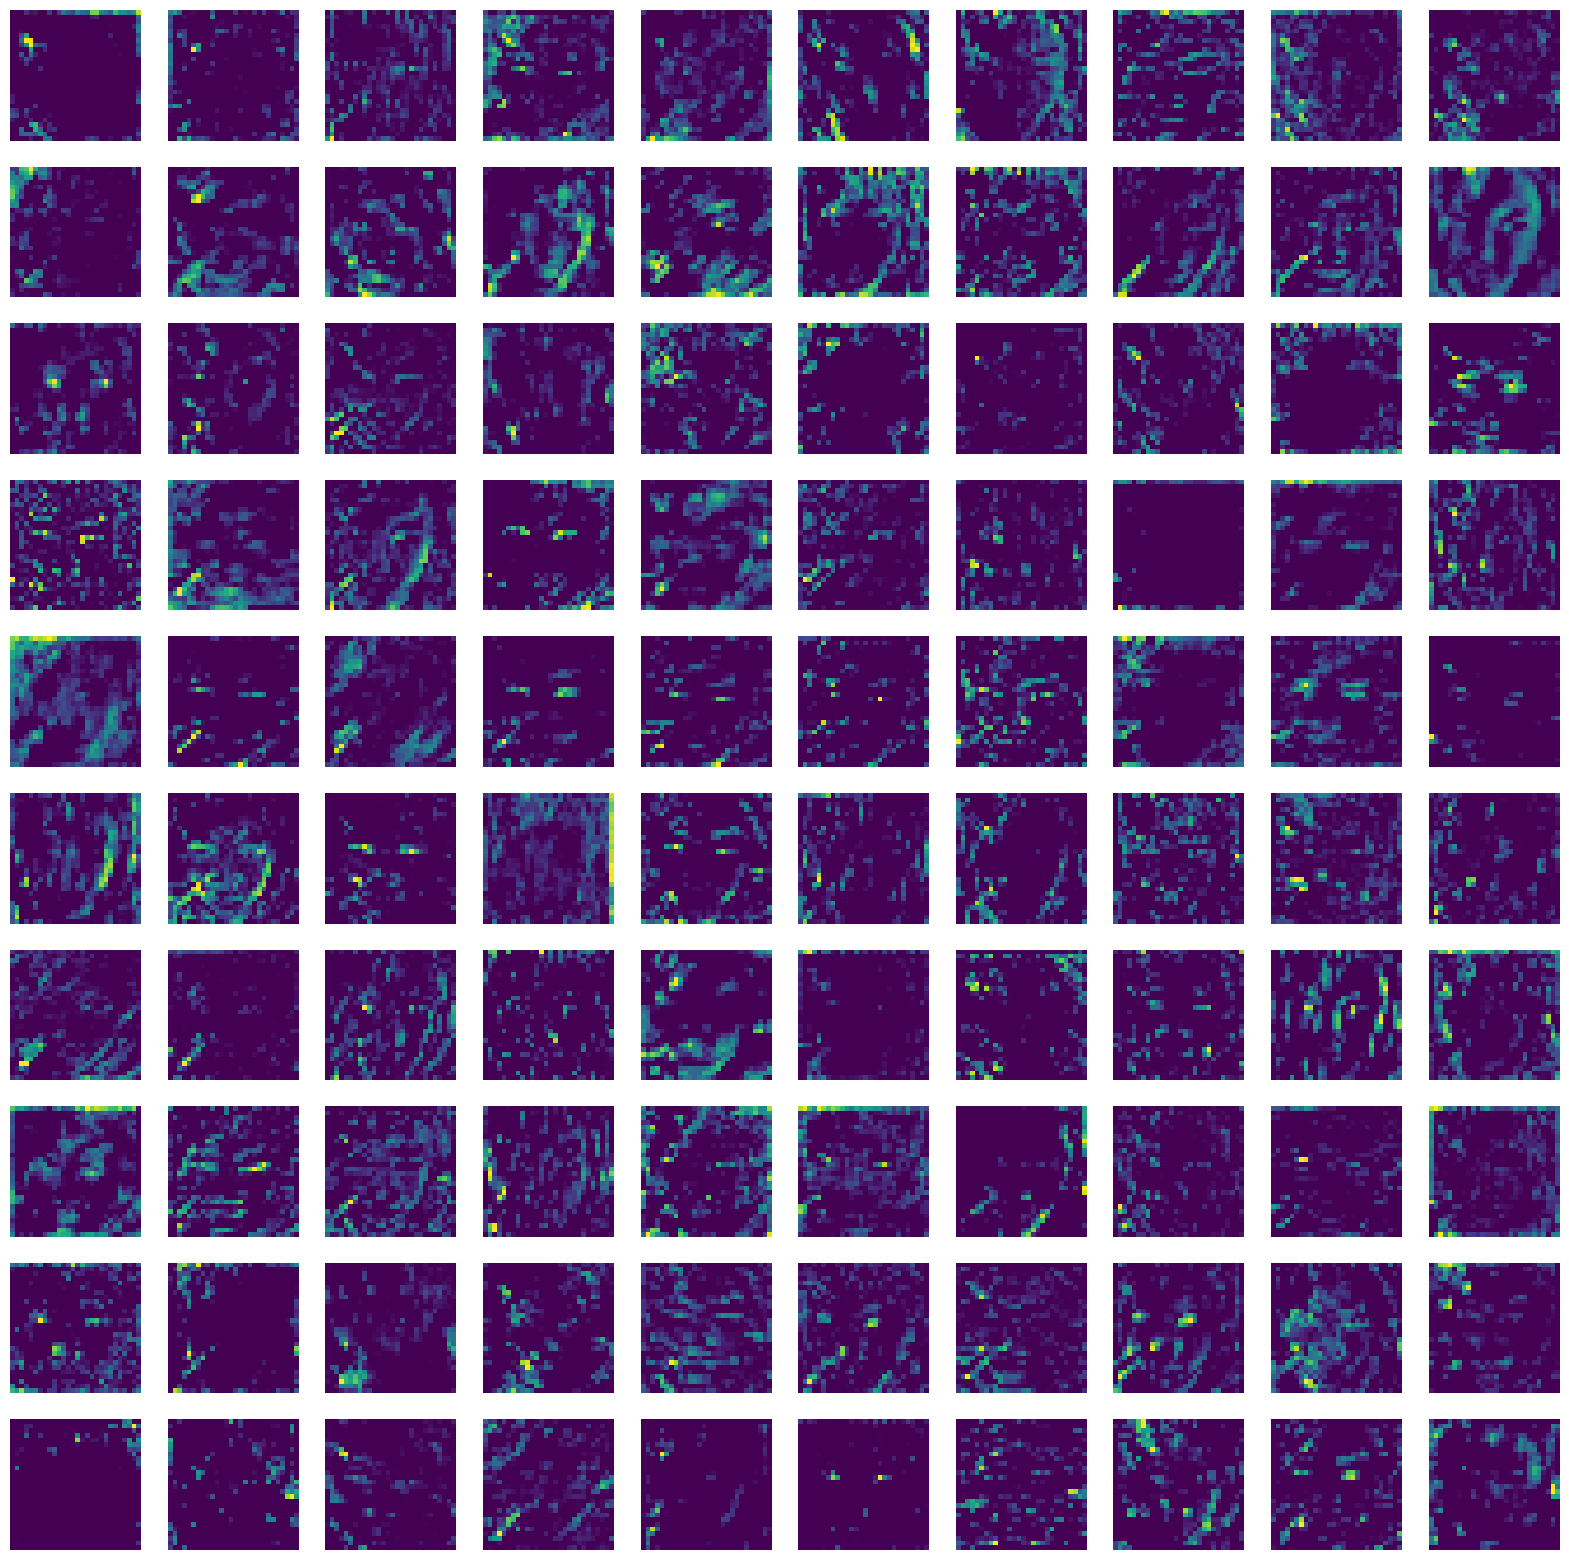

In [28]:
# 使用预训练模型和图像进行特征图可视化
image_path = './images/bz_color.jpg'  # 更改为你的图像路径
inputs = preprocess_image(image_path)

# 调用 plot_feature 函数来可视化特征图
plot_feature(model, 10, inputs)  # 使用第一个卷积层的特征图

### 2.3 CNN class activation map(CAM) 方法

class activation map （CAM）的作用是判断哪些变量对模型来说是重要的，在CNN可视化的场景下，即判断图像中哪些像素点对预测结果是重要的。

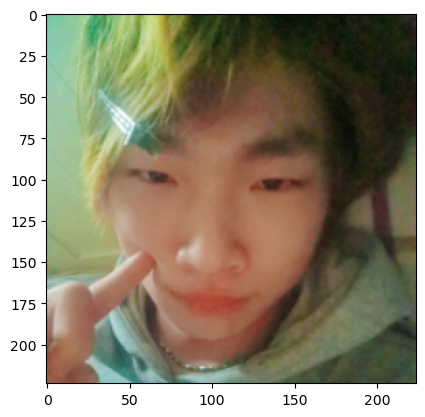

In [35]:
img_path = './images/bz_color.jpg'
# resize操作是为了和传入神经网络训练图片大小一致
img = Image.open(img_path).resize((224,224))
# 需要将原始图片转为np.float32格式并且在0-1之间 
rgb_img = np.float32(img)/255
plt.imshow(img)

hooker working <__main__.Hook object at 0x000001A7DD99D3D0>
hooker working <__main__.Hook object at 0x000001A8863262D0>
hooker working <__main__.Hook object at 0x000001A7EB2EF610>
hooker working <__main__.Hook object at 0x000001A83CB9EE50>
hooker working <__main__.Hook object at 0x000001A85177FF50>
hooker working <__main__.Hook object at 0x000001A70D892210>
hooker working <__main__.Hook object at 0x000001A8599D0650>
hooker working <__main__.Hook object at 0x000001A85B9F1E90>
hooker working <__main__.Hook object at 0x000001A837693390>
hooker working <__main__.Hook object at 0x000001A83C7978D0>
hooker working <__main__.Hook object at 0x000001A850AE0950>
<class 'numpy.ndarray'>


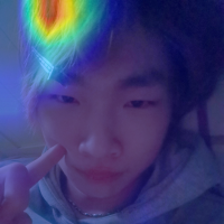

In [39]:

# 将图片转为tensor
img_tensor = torch.from_numpy(rgb_img).permute(2,0,1).unsqueeze(0)

target_layers = [model.features[-1]]
# 选取合适的类激活图，但是ScoreCAM和AblationCAM需要batch_size
cam = GradCAM(model=model,target_layers=target_layers)
targets = [ClassifierOutputTarget(200)]   
# 上方preds需要设定，比如ImageNet有1000类，这里可以设为200
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)

'wget' is not recognized as an internal or external command,
operable program or batch file.
